In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
sp.init_printing(use_unicode=True)

In [3]:
class Optic:
    def __init__(self, pos, length, radius, name):
        self.pos = pos # starting position
        self.length = length
        self.radius = radius
        self.name = name
        
    def draw_optic(self):
        pass
        
class ThinLens(Optic):
    '''
        Thin lens object that affects rays according to the thin-lens approximation
    '''
    def __init__(self, pos, f, radius=12.5, name='null'):
        super().__init__(pos, length=0, radius=radius, name=name)
        self.f = f
        self.matrix = np.array([[1, 0], [-1/f, 1]])
        
    def draw_optic(self):
        plt.plot([self.pos, self.pos], [-self.radius, self.radius], color='black')
        plt.text(self.pos, self.radius, self.name +'='+str(self.f), va='bottom', ha='center')
        
class Screen(Optic):
    '''
        A null optic that is used to record ray coordinates at specific points or force
        ray propagation to a particular point after available lenses
    '''
    def __init__(self, pos):
        super().__init__(pos, length=0, radius=0, name='screen')
        self.matrix = np.array([[1,0],[0,1]])

In [4]:
class Ray:
    '''
        Class for Rays that propagate through the system
        Angles (theta) MUST be in RADIANS.
    '''
    def __init__(self, x_i, y_i, theta_i, color):
        self.coords = [np.array([y_i, theta_i])]
        self.x_vect = [x_i]
        self.y_vect = [y_i]
        self.color = color
        
    def draw_ray(self):
        plt.plot(self.x_vect, self.y_vect, color=self.color)
        
def deg2rad(degrees):
    '''
        Helper method for quick degree-to-radian conversion
    '''
    return np.pi * degrees / 180

In [15]:
class System():
    def _sort_optics(self, unsorted):
        return sorted(unsorted, key=lambda x: x.pos)
    
    def __init__(self):
        self.optics = []
        self.rays = []
        
        self.lens_count = 0
        
    
    def propagate(self):
        for ray in self.rays:
            for optic in self.optics:
                if ray.x_vect[-1] > optic.pos:
                    # If the ray is infront of the optic do nothing
                    pass
                
                else:
                    # Propagate to the optic
                    dist_to_optic = optic.pos - ray.x_vect[-1]
                    matrix_to_optic = np.array([[1, dist_to_optic],[0, 1]])
                    in_coords = matrix_to_optic @ ray.coords[-1]
                    
                    # Update ray 
                    ray.coords.append(in_coords)
                    ray.x_vect.append(optic.pos)
                    ray.y_vect.append(in_coords[0])
                    
                    # If ray exceeds optic radius...
                    if np.abs(ray.y_vect[-1]) > optic.radius:
                        # then stop propagating
                        break
                    
                    
                    # Otherwise: propagate through the optic
                    out_coords = optic.matrix @ ray.coords[-1]
                    
                    # Update ray
                    ray.coords.append(out_coords)
                    ray.x_vect.append(ray.x_vect[-1] + optic.length)
                    ray.y_vect.append(out_coords[0])
        
    
    
    # Draw system and its parts
    def draw_optics(self):
        for optic in self.optics:
            optic.draw_optic()
            
    def draw_rays(self):
        for ray in self.rays:
            ray.draw_ray()
        
        
    # Handling of optics within system
    # ---- General usage
    def clear_optics(self):
        '''
            Removes all optics, resets counters
        '''
        self.optics = []
        self.lens_count = 0
        
        
    def remove_optic(self, name):
        '''
            Removes the first instance of a lens with name of argument
        '''
        for optic in self.optics:
            if optic.name == name:
                self.optics.remove(optic)
                break
        else:
            raise ValueError('Optic with name '+ name +' was not found.')
                
        
        
    # ---- Lenses only
    def gen_name(self):
        self.lens_count = self.lens_count + 1
        return 'f' + str(self.lens_count)
        
    def add_ThinLens(self, f, pos=None, rel_pos=None, radius=12.5, name='null'):
        '''
            Method to add a ThinLens object to the microscope system
            Arguments:
                - f = focal length of thin lens
                - ONLY ONE OF:
                    (1) pos = exact position
                    (2) rel_pos = relative to optic with furthest down the path
                    
                    ** Both cannot be simultaneously defined.
                    ** At least one must be defined
                - radius = optic radius (1-inch diameter by default)
                - name = name of optic if specified
        '''
        
        # If not named, generate a name
        if name is 'null':
            name = self.gen_name()
            
        # Determine position
        if pos is not None and rel_pos is not None:
            raise ValueError('Exact and relative positions cannot be simultaneously defined')
            
        elif pos is None:
            position = self.optics[-1].pos + rel_pos
            
        else:
            position = pos
            
        # Append create new lens and add to system, sort optics into order   
        self.optics.append(ThinLens(position, f, radius, name))
        self.optics = self._sort_optics(self.optics)
        
    def update_lens(self, name, f, pos=None, rel_pos=None, radius=12.5):
        '''
            Updates lens by removing and replacing lens with same name
            
            NOTE: memory inefficient -- should update later...
        '''
        self.remove_optic(name)
        self.add_ThinLens(f, pos, rel_pos, radius, name)
        
        
            
    # Rays        
    def add_Ray(self, x_i, y_i, theta_i, color='green'):
        self.rays.append(Ray(x_i, y_i, theta_i, color))
        
    def add_beam(self, x_i, y_i, radius, theta_i=0, color='green', dense=False):
        '''
            Adds a collimated beam with cross-sectional radius given by input argument
        '''
        eff_rad = radius*np.cos(theta_i) # Radius of spot projected on screen
        
        self.rays.append(Ray(x_i, y_i, theta_i, color))
        self.rays.append(Ray(x_i, y_i+eff_rad, theta_i, color))
        self.rays.append(Ray(x_i, y_i-eff_rad, theta_i, color))
        
        if dense is True:
            self.rays.append(Ray(x_i, y_i+(eff_rad/2), theta_i, color))
            self.rays.append(Ray(x_i, y_i-(eff_rad/2), theta_i, color))
        
    def add_point(self, x_i, y_i, theta_max, color='green', dense=False):
        '''
            Adds point source with outgoing rays upto theta_max
        '''
        self.rays.append(Ray(x_i, y_i, 0, color))
        self.rays.append(Ray(x_i, y_i, theta_max, color))
        self.rays.append(Ray(x_i, y_i, -theta_max, color))
        
        if dense is True:
            self.rays.append(Ray(x_i, y_i, theta_max/2, color))
            self.rays.append(Ray(x_i, y_i, -theta_max/2, color))
    
    def clear_rays(self):
        self.rays = []
            
            
    # Screen
    def add_Screen(self, pos=None, rel_pos=None):
        # Determine position
        if pos is not None and rel_pos is not None:
            raise ValueError('Exact and relative positions cannot be simultaneously defined')
            
        elif pos is None:
            position = self.optics[-1].pos + rel_pos
            
        else:
            position = pos
            
        # add and sort
        self.optics.append(Screen(position))
        self.optics = self._sort_optics(self.optics)

# Example usage

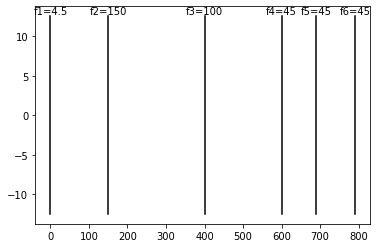

In [21]:
microscope = System()

microscope.add_ThinLens(pos=0, f=4.5)
microscope.add_ThinLens(rel_pos=150, f=150)
microscope.add_ThinLens(rel_pos=250, f=100)
microscope.add_ThinLens(rel_pos=200, f=45)
microscope.add_ThinLens(rel_pos=90, f=45)
microscope.add_ThinLens(rel_pos=100, f=45)
microscope.add_Screen(rel_pos=45)
microscope.draw_optics()

In [22]:
microscope.add_point(x_i=-4.5, y_i=0, theta_max=0.65)
microscope.add_point(x_i=-4.5, y_i=0.1, theta_max=0.65, color='red')
microscope.add_point(x_i=-4.5, y_i=0.25, theta_max=0.65, color='blue')
microscope.propagate()

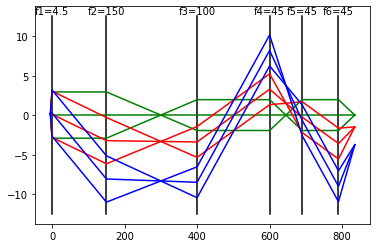

In [23]:
microscope.draw_optics()
microscope.draw_rays()